# Test Vector Leakage Assessment

An example.

### 1. Generating examples

In this example, there are two keys $k_a$ and $k_b$. For each of these 2 keys, there are $1000$ power traces (samples)
available, each with a length of $1400$ sample points.

In [2]:
from numpy.random._generator import default_rng
from src.data.slices import make_slice
from src.tvla.t import make_t_test
from src.tvla.main import tvla

samples = 1000
sample_pts = 1400

The samples for these imaginary traces will be simplified into normal distributions with mean $\mu$.

A first-order "leakage" will be simulated by taking $\mu_a$ (for key $k_a$) slightly bigger than $\mu_b$.

In [3]:
mu_a = 42.2
mu_b = 42

In [4]:
import numpy as np

# Refer to section statistical properties of ASCAD in books/data/ascad_normality.
sigma = .2

traces_key_a = np.array([np.random.normal(size=samples, scale=sigma) + mu_a for _ in range(sample_pts)], dtype=int)
traces_key_b = np.array([np.random.normal(size=samples, scale=sigma) + mu_b for _ in range(sample_pts)], dtype=int)

### 2. Slicing the input

The first step in TVLA is to split these samples into four disjoint slices, each with a length of $250$.

The $n$-th slice for key $k_a$ will be denoted as $A_n$.

In [5]:
A = make_slice(np.moveaxis(traces_key_a, 0, -1))
B = make_slice(np.moveaxis(traces_key_b, 0, -1))

In [6]:
A.shape

(4, 250, 1400)

### 3. Preparing the data

In this example, the t-test is used when performing TVLA. The t-test takes the sample mean, sample variance and some
value for $p$. It tests the null hypothesis that 2 independent samples have identical average (expected) values, and
returns whether the null hypotheses should be accepted.

Therefore, $A$ and $B$ need to be transformed to fit the input parameters of the t-test.

In [7]:
A_mv = np.moveaxis(np.array((A.mean(axis=1), A.var(axis=1))), 0, -1)
B_mv = np.moveaxis(np.array((B.mean(axis=1), B.var(axis=1))), 0, -1)

A_mv.shape

(4, 1400, 2)

### 4. Applying TVLA

Create the t-test, as it relies on the number of observations (not included with the mean and variance).

In [8]:
num_observations = A.shape[2]
t_test = make_t_test(num_observations)

Apply TVLA using Welch's t-test.

In [9]:
tvla(test=t_test, left=A_mv, right=B_mv, p=5)

(True, False)

# SMOTE the dataset

[(39.0, 45.0)]

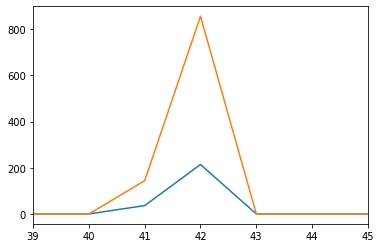

In [11]:
def smote(samples_key, preferred_size=-1):
    if preferred_size < 0:
        preferred_size = max([len(sk) for sk in samples_key])

    res_shape = list(samples_key.shape)
    res_shape[1] = preferred_size

    res = np.zeros(res_shape)

    for ix, slice_key in enumerate(samples_key):
        num_smote = preferred_size - len(slice_key)
        assert num_smote >= 0

        s_from = np.random.uniform(0, len(slice_key), num_smote).astype(int)
        s_to = (s_from + np.random.uniform(1, len(slice_key), num_smote).astype(int)) % len(slice_key)

        smote_d = slice_key[s_from] - slice_key[s_to]
        smote_res = np.round(slice_key[s_to] + smote_d * np.random.uniform(size=smote_d.shape)).astype(int)

        res[ix][:len(slice_key)] = slice_key
        res[ix][len(slice_key):] = smote_res

    return res

sA = smote(A, 1000)

import seaborn as sns

sns.lineplot(data=np.bincount(np.moveaxis(A[0], 0, -1)[0], minlength=A.shape[2])).set(xlim=(39, 45))
sns.lineplot(data=np.bincount(np.moveaxis(sA[0], 0, -1)[0].astype(int), minlength=A.shape[2])).set(xlim=(39, 45))

In [12]:
A.mean(), sA.mean()

(41.84155428571429, 41.84185446428572)

In [13]:
A.var(), sA.var()

(0.1333949556244898, 0.13318409667649878)